In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle
import math

from architectures.DVAE import *

In [2]:
# some constants

LEARNING_RATE = 0.0001
BETA1 = 0.5
BATCH_SIZE = 128
EPOCHS = 10
SAVE_SAMPLE_PERIOD = 860

task='TRAIN'
#task='TEST'
PATH='DVAE_test'
SEED=1

In [3]:
trunc_normal= tf.truncated_normal_initializer(stddev=0.02, seed=SEED)
normal = tf.random_normal_initializer(stddev=0.02, seed=SEED)
glorot_normal = tf.glorot_normal_initializer(seed=SEED)

global e_sizes, d_sizes
e_sizes = {'dense_layers':[(512, 'bn', 1, tf.nn.relu, glorot_normal),
                           (384, 'bn', 1, tf.nn.relu, glorot_normal),
                           (256, False, 1, tf.nn.relu, glorot_normal)],
           'readout_layer_w_init':glorot_normal,
           'z':10,
}
d_sizes = { 'dense_layers':[(256, False, 1, tf.nn.relu, glorot_normal),
                            (384, 'bn', 1, tf.nn.relu, glorot_normal),
                            (512, 'bn', 1, tf.nn.relu, glorot_normal),],
           'readout_layer_w_init':glorot_normal,
}

In [4]:
def mnist():

    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
    
    X_train = mnist.train.images
    #X_train = (X_train>0.5).astype(np.float32)
    
    X_test = mnist.test.images
    #X_test = (X_test>0.5).astype(np.float32)

    dim = X_train.shape[1]
    
    tf.reset_default_graph()
    vae = DVAE(dim, e_sizes, d_sizes,
              lr=LEARNING_RATE, beta1=BETA1,
              batch_size=BATCH_SIZE, epochs=EPOCHS,
              save_sample= SAVE_SAMPLE_PERIOD, path=PATH, seed=SEED, img_height=28, img_width=28 )
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            vae.set_session(sess)
            vae.fit(X_train)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            vae.set_session(sess)
            
        done = False
        i=0
        while not done:
            
            im = vae.get_sample()

            plt.imshow(im.reshape(28,28), cmap='gray')
            plt.title('Sampled')
            
            fig = plt.gcf()
            fig.set_size_inches(5, 5)
            plt.savefig(PATH+'/sampled_from_dist_%d.png' % i,dpi=100)
            plt.show()
            i+=1
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True
            

A previous checkpoint already exists, choose the action to perform 
 
 1) Overwrite the current model saved at DVAE_test/checkpoint 
 2) Start training a new model 
 3) Restore and continue training the previous model 
 1
Overwriting existing model in DVAE_test
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Encoder output shape (?, 10)
10

 Training...

 ****** 

Training deep VAE with a total of 55000 samples distributed in batches of size 128

The learning rate set is 0.0001, and every 860 iterations a generated sample will be saved to DVAE_test

 ****** 

Epoch: 0
Epoch: 1
At iteration: 860  -  dt: 0:00:01.594217 - cost: 1.34
Saving a sample...
Epoch: 2
Epoch: 3
At iteration: 1720  -  dt: 0:00:01.583438 - cost: 1.04
Saving a sample...
Epoch: 4
Epoch: 5
At iteration: 2580  -  dt: 0:00:01.582110 - cost: 0.96
Saving a sample...
Epoch: 6
Epoc

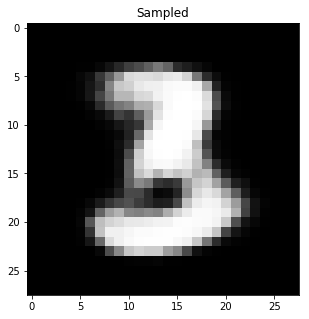

Generate another?


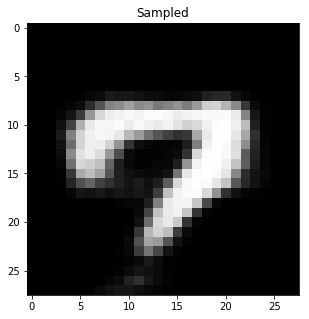

Generate another?


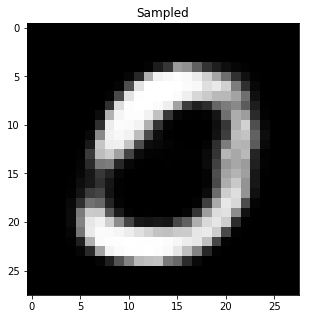

Generate another?


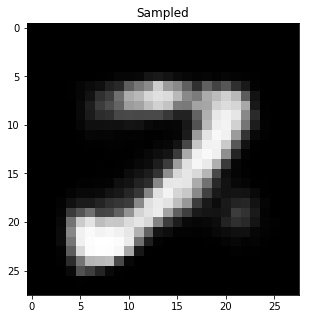

Generate another?


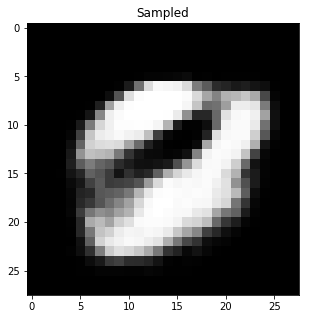

Generate another?


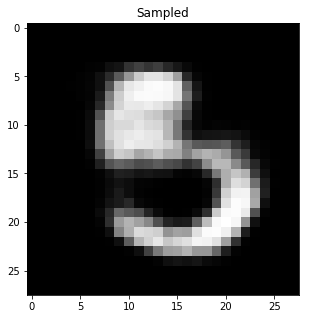

Generate another?


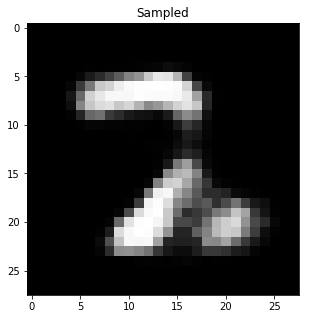

Generate another?


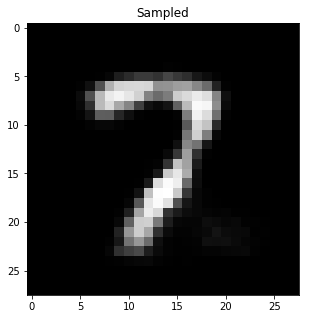

Generate another?n


In [5]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        mnist()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            mnist()